# Sta 663 Final Project: Implementation of DCMMs {-}

#### Author: Daniel Deng, Ziyuan Zhao (Equally contributed)

### Paper used: Bayesian forecasting of many count-valued time series {-}

### Installation {-}

Use the following line to install the package

required packages:

pip install pybats

pip install matplotlib

pip install pandas

pip install numpy

pip install statsmodels

pip install scipy

This package: pip install -i https://test.pypi.org/simple/ Sta663-DCMMs==2.2.7

GitHub: https://github.com/Anluzi/Ziyuan-Daniel_DCMMs

### Abstract {-}

When it comes to sporadic data with many zero observations, special treatment is needed. This project implements a novel algorithm named Dynamic Count Mixture Models, to customize this kind of data. The model framework is throughout Bayesian and the decouple/recouple concept allows parallel fast computation, via maintaining scalability and interpretability of indiviudal series.
Key words: Bayesian framework, Dynamic Count Mixture Models, Decouple/Recouple, Scalability, Parallel computation

### Background {-}

One hallmark of forecasting sporadic count-valued data is for the model to account for many zero observations. This can be a problem for a single Poisson model, since no Poisson distribution gives such a distribution. When one takes a very small mean, it accounts for the zeros, but this will lead to almost zero probability of observing any moderately larger positive values. Dynamic Count Mixture Models consider zero and non-zero observations separately, by introducing a latent factor $z_t$, which indicates whether or not there is a sale. The details are the following:

\begin{align}
\begin{split} 
&z_t \sim Ber(\pi_t) \\
&y_t | z_t = 
\begin{cases}
0, &z_t = 0 \\
1 + x_t, x_t \sim Po(\mu_t), &z_t = 1
\end{cases} \\
\end{split}
\label{eq:exampleEq}
\end{align}

\begin{align}
\begin{split} 
\text{model equations}
\begin{cases}
&logit(\pi_t) = F_t^0\xi_t \\
&log(\mu_t) = F_t^+\theta_t \\
\end{cases}
\end{split}
\label{eq:exampleEq}
\end{align}



$F_t^0$ and $F_t^+$ are regressors, $\xi_t$ and $\theta_t$ are state vectors  for Bernoulli and Poisson respectively, which evolve separately. $y_t$ gets updated only when $z_t = 1$.

Another advantage of this model is that under its Bayesian framework, one can easily obtain the full trajectory of $y_t$ and uncertainty via direct simulation.

Compared to other existing common methods for count-valued data, such as static generalized linear models, the biggest advantage for DCMMs is its time-varying and updating feature. The coefficients in the state vector $\xi_t$ and $\theta_t$ are constantly updated with time, depending on the observation at time t $z_t$ and $y_t$.

This project will explore the details of this mixture model and implement it on both simulated data and one real data.

### Algorithm Details {-}

As the name suggests, DCMMs are a mixture model of Bernoulli and Poisson DGLMs, which are both members of a larger family: Dynamic Generalized Linear Models (DGLMs). When implementing DCMMs, one fits Bernoulli and Poisson models separately, using the data observed, while upon forecasting, predictions from Poisson model depend on the predictions of Bernoulli model, as stated in the last section above. Since DCMMs are novel usage of __Dynamic Generalized Linear Models__, below are the details of DGLMs:

#### Notions and Structure {-}

- $y_t$ denotes the time series of interest, which, in the case of this paper, is the sales. It can be binary or non-negative counts.
- At any given time t, available information is denoted by $D_t = \{y_t, D_{t-1}, I_{t-1}\}$, where $I_{t-1}$ is any relevant additional information at time $t-1$.
- *$F_t, \theta_t$* are the dynamic regression vector and state vector at time $t$, respectively.
- $\lambda_t = F_t' \theta_t$, where $\lambda_t$ is the linear predictor at time $t$. It links the parameter of interest and the linear regression via link functions, 

    - i.e., $\lambda_t = logit(\pi_t)$ for binomial DGLM and $\lambda_t = log(\mu_t)$ for Poisson DGLM, where $\pi_t, \mu_t$ are probability of success and mean for these precesses.
- state vector $\theta_t$ evolves via $\theta_t = G_t \theta_t + w_t$ and $w_t \sim (0, W_t)$, where $G_t$ is the known evolution matrix and $w_t$ is the stochastic innovation vector.
- $w_t$ is independent of current and past states with moments $E[w_t|D_{t-1}, I_{t-1}] = 0$ and $V[w_t|D_{t-1}, I_{t-1}] = W_t$



The __updating__ and __forecasting__ cycle from t-1 to t for a DGLM is implemented as described below, examples for Bernoulli and Poisson are given:

1. Current information is summarized in mean vector and variance matrix of the posterior state vector $\theta_{t-1} | D_{t-1}, I_{t-1} \sim [m_{t-1}, C_{t-1}]$.

2. Via the evolution equation $\theta_t = G_t \theta_t + w_t$, the implied 1-step ahead prior moments at time $t$ are $\theta_t | D_{t-1}, I_{t-1} \sim [a_t, R_t]$, with $a_t = G_tC_{t-1}G_t'$ and $R_t = G_tC_{t-1}G_t' + W_t$.

3. The time $t$ conjugate prior satisfies $E[\lambda_t|D_{t-1}, I_{t-1}] = f_t = F_t'a_t$ and $V[\lambda_t|D_{t-1}, I_{t-1}] = q_t = F_t'R_tF_t$. 

    - i.e. 
    Binomial: $y_t \sim Bin(h_t, \pi_t)$, conjugate prior: $\pi_t \sim Be(\alpha_t, \beta_t)$, with $f_t = \psi(\alpha_t) - \psi(\beta_t)$ and $q_t = \psi'(\alpha_t) + \psi'(\beta_t)$, where $\psi(x), \psi'(x)$ are digamma and trigamma functions. 
    Poisson: $y_t \sim Poi(\mu_t)$, conjugate prior: $\mu_t \sim Ga(\alpha_t, \beta_t)$, with $f_t = \psi(\alpha_t) - log(\beta_t)$ and $q_t = \psi'(\alpha_t)$.

4. Forecast $y_t$ 1-step ahead using the conjugacy-induced predictive distribution $p(y_t|D_{t-1}, I_{t-1})$. This can be simulated trivially.

5. Observing $y_t$, update to the posterior. 

    - i.e. 
    Binomial: conjugate posterior: $\pi_t \sim Be(\alpha_t + y_t, \beta_t + h_t - y_t)$. 
    Poisson: conjugate posterior $\mu_t \sim Ga(\alpha_t + y_t, \beta_t + 1)$.

6. Update posterior mean and variance of the linear predictor $\lambda_t$: $g_t = E[\lambda_t|D_t]$ and $p_t = V[\lambda_t|D_t]$

7. Linear Bayes estimation gives posterior moments $m_t = a_t + R_tF_t(g_t - f_t)/q_t$ and $C_t = R_t - R_tF_tF_t'R_t'(1 - p_t/q_t)/q_t$ 

This completes the time $t-1$-to-$t$ evolve-predict-update cycle.

__Random effect discount factors__ are tunning parameters for DCMMs. Details are the following:

- Applicable to any DGLMs.
- Capture additional variation.
- Extended state vector: $\theta_t = (\xi_t, \theta_{t,0}')'$ and regression vector: $F_t' = (1, F_{t,0}')'$, where $\xi_t$ is a sequence of independent, zero-mean random effects and $\theta_{t,0}',F_{t,0}'$ are the baseline state vector and regression vector. Extended linear predictor: $\lambda_t = \xi_t + \lambda_{t,0}$
- $\xi_t$ provides an additional, day-specific "shocks" to latent coefficients.
- A random effect discount factor $\rho \in (0,1]$ is used to control the level of variability injected (via a similar fashion as the other discount factors): \\
i.e. \\
$q_{t,0} = V[\lambda_{t,0}|D_{t-1},I_{t-1}]$, let $v_t = V[\xi_t|D_{t-1}, I_{t-1}] = q_{t,0}(1-\rho)/\rho$, which inflates the variation of $\lambda_t$ by $(1-\rho)/\rho$

### Optimization {-}

This algorithm is designed for parallelism, so we compare the performance with and without parallel programming.

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
from Sta663DCMMs.Examples import real_example, sim_example
from Sta663DCMMs.Data import load_james_three, load_sim_data
from Sta663DCMMs.Comparison_examples import glm_example, dglm_example

In [53]:
data = load_james_three()
# discount factors
rhos = [0.9]*len(data)

beginning forecasting
beginning forecasting
beginning forecasting
beginning forecasting


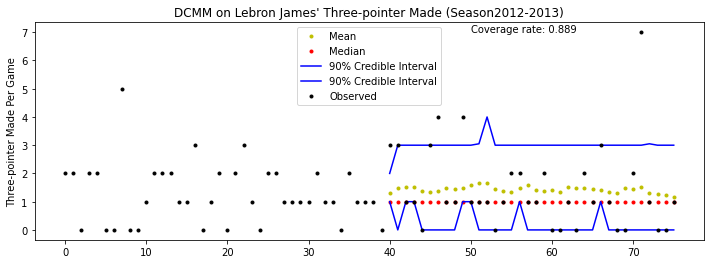

beginning forecasting
beginning forecasting
beginning forecasting
beginning forecasting


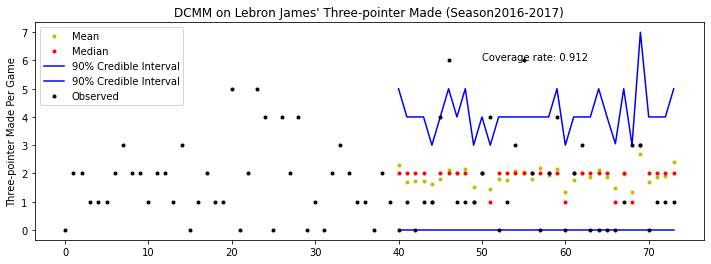

beginning forecasting
beginning forecasting
beginning forecasting
beginning forecasting


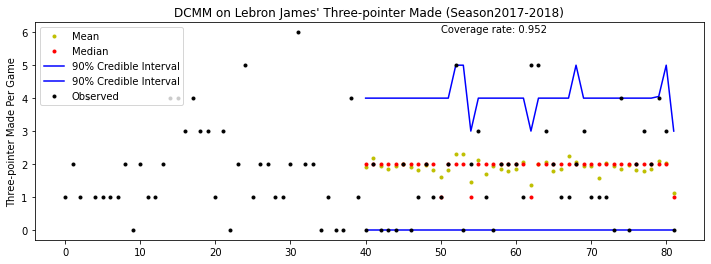

CPU times: user 668 ms, sys: 12.2 ms, total: 680 ms
Wall time: 671 ms


In [54]:
%%time

for df, rho in zip(data,rhos):
    real_example(df, rho)

In [55]:
from joblib import Parallel, delayed

In [57]:
%%time
Parallel(n_jobs=3)(delayed(real_example)(df, rho) for df, rho in zip(data,rhos))

CPU times: user 4.78 ms, sys: 25 µs, total: 4.8 ms
Wall time: 114 ms


[None, None, None]

It can be seen that with parallel computation, fitting three models costs about __one sixth__ of the one without parallelism.

### Simulated Example {-}

In [31]:
load_sim_data()

,sales,promotion,price
0,2,1,2.45
1,6,1,2.69
2,4,1,2.76
3,0,0,5.42
4,0,0,4.81
...,...,...,...
107,3,1,2.66
108,2,1,1.81
109,2,1,2.77
110,0,0,4.89


beginning forecasting
beginning forecasting
beginning forecasting
beginning forecasting


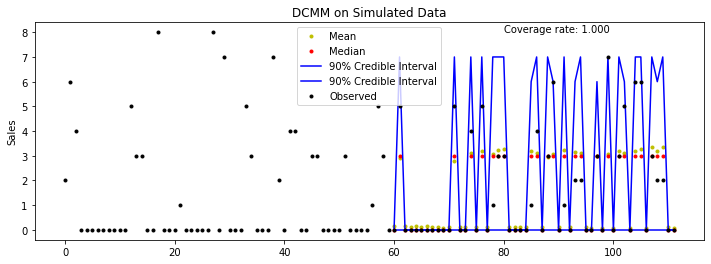

In [49]:
sim_example()

Above shows the results of DCMM on a simulated sales data, using promotion indicator and net price as covariates. The model does a perfect job in terms of 90% coverage rate. Also, the black points (reality) and the yellow points (model mean) are almost identical.

### Real Example {-}

Below is a dataset of three-pointer made by Lebron James in 2017-2018 season. _home_ is the indicator of whether or not it is a home game and _minutes_ is the minutes Lebron played in that game.

In [35]:
data = load_james_three()[2]
data

,date,three_made,home,minutes
0,2017-10-17,1,1,41
1,2017-10-20,2,0,37
2,2017-10-21,1,1,31
3,2017-10-24,4,1,37
4,2017-10-25,1,0,41
...,...,...,...,...
77,2018-04-03,3,1,37
78,2018-04-05,2,1,38
79,2018-04-06,4,0,40
80,2018-04-09,3,0,38


In [36]:
rho = 0.9 # discount factor for the model

beginning forecasting
beginning forecasting
beginning forecasting
beginning forecasting


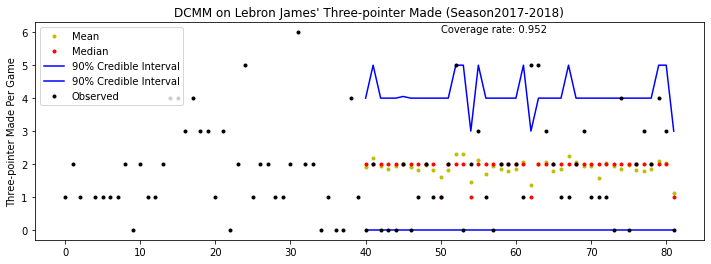

CPU times: user 276 ms, sys: 3.33 ms, total: 280 ms
Wall time: 275 ms


In [37]:
%%time
real_example(data, rho)

Above shows an example of DCMM on a real dataset. It does a great job, having a 95.2% coverage rate. It can be seen that the model adapts to the data and changes its posteriors, thus predictions.

### Comparison {-}

Two competitors for DCMMs are 1. Poisson GLM and 2. Poisson Dynamic GLM

#### Poisson GLM {-}

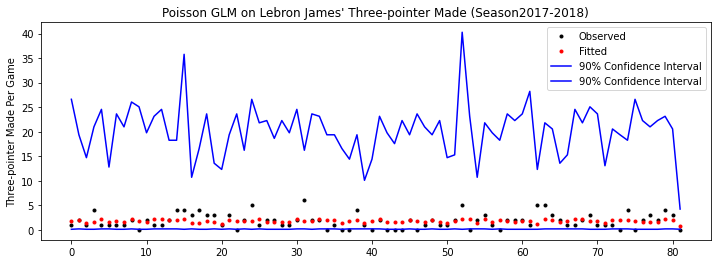

CPU times: user 776 ms, sys: 9.24 ms, total: 785 ms
Wall time: 203 ms


In [38]:
%%time
glm_example(data)

From the performance results of a static Poisson GLM above, we can see that the 90% confidence intervals are so much wider than the ones obtained from DCMM (even though it covers all the points, it has no practical use), which indicates this model does not have great precision. The time cost is practically the same and the DCMM example, there is one more variable (median) to plot. Therefore, a static Poisson GLM is not suitable for this kind of problem, compared to DCMM.

#### Poisson DGLM {-}

beginning forecasting
beginning forecasting


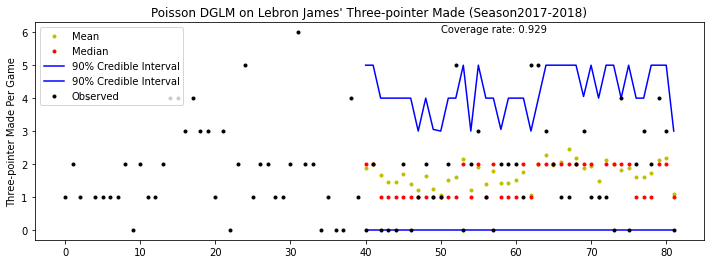

CPU times: user 226 ms, sys: 0 ns, total: 226 ms
Wall time: 223 ms


In [39]:
%%time
# use the same discount factor
dglm_example(data, rho)

From the model performance results of Poisson DGLM, we can see that the coverage is slightly lower than DCMM, while maintaining a reasonable credible interval (slightly narrower than DCMM's). When it comes to time cost, this is perceivably shorter than DCMM, since DCMM is one Poisson DGLM on top of a Bernoulli DGLM.

Comparison summary: Bayesian Dynamic models easily beat static GLM, while DCMMs slightly outperform Poisson DGLM. Advantage of DCMMs would have be displayed more if the data are more sporadic (with more zeros).

### Discussion {-}

Since DCMMs are designed to sporadic count-valued data, naturally it does a good job for these data. Despite that it is hard to see it being generalized to other kinds of data, the core idea of it which is the mixture and hierarchical structure, can be further explored. One possible model structure is Dynamic Binary Cascade Models (DBCMs), proposed by Lindsay Berry and Mike West (2020). Details are shown below.

- $n_{r,t}$ is the number of transactions with more than r units (sales).
- For each $r = 1:d$ ($r=0$ is a trial case.), where d is a specified positive integer, $\pi_{r,t}$ is the probability that the sales for a particular transaction exceeds r, given it exceeds $r-1$.
- For each $r = 1:d$, $n_{r,t} | n_{r-1, t} \sim Bin(n_{r-1, t}, \pi_{r, t})$, which is the sequence of conditional binomial distributions.
- The conditional model of $n_{r,t}$ has the dynamic binomial logistic form: $n_{r,t} | n_{r-1, t} \sim Bin(n_{r-1, t}, \pi_{r, t})$ where $logit(\pi_{r,t}) = F^0_{r,t} \xi_{r,t}$, with known dynamic regression vector $F^0_{r,t}$ and latent state vector $\xi_{r,t}$.
- $e_t \ge 0$ is the count of excess sales (more than d items). 

Comments: DBCMs are essentially cascades of Binomial DGLMs with the successor conditioned on the adjacent precedent.

When it comes to promotion on the model, there still remain a lot of work. For example, the discount factor can be time adaptive, giving the model just enough variation to account for the data, but restraining it from exploding. Also, covariates for the model can be adaptive, too, which concerns some theoretical derivations.

### Appendix {-}

Below are the example codes for Lebron's 3P data, using dcmm_analysis():

In [59]:
# ## premodeling process
#     Y = data.loc[:, 'three_made'].values
#     X = [data.loc[:, ['home', 'minutes']].values]
#     prior_length = 4
#     nsamps = 500
#     forecast_start = 40
#     forecast_end = len(Y)-1

#     ## extract df info
#     s = sorted(set([d[:4] for d in data.date]))

#     ## fitting the model
#     samples, mod, coef = dcmm_analysis(Y, X, prior_length=prior_length, nsamps=nsamps,
#                                        forecast_start=forecast_start, forecast_end=forecast_end,
#                                        mean_only=False, rho=rho, ret=['forecast', 'model', 'model_coef'])
#     ## obtain the mean, median and bounds of 90% credible interval
#     avg = dcmm_analysis(Y, X, prior_length=prior_length, nsamps=nsamps,
#                         forecast_start=forecast_start, forecast_end=forecast_end,
#                         mean_only=True, rho=rho, ret=['forecast'])[0]
#     med = np.median(samples, axis=0)

#     upper = np.quantile(samples, 0.95, axis=0)
#     lower = np.quantile(samples, 0.05, axis=0)

#     ## calculate coverage
#     forecast_period = np.linspace(forecast_start, forecast_end, forecast_end - forecast_start + 1)
#     coverage = np.logical_and(Y[40:] <= upper, Y[40:] >= lower).sum() / len(forecast_period)

#     ## make the plot
#     fig, ax = plt.subplots(figsize=(12, 4))
#     ax.plot(forecast_period, avg, '.y', label='Mean')
#     ax.plot(forecast_period, med, '.r', label='Median')
#     ax.plot(forecast_period, upper, '-b', label='90% Credible Interval')
#     ax.plot(forecast_period, lower, '-b', label='90% Credible Interval')
#     ax.plot(Y, '.k', label="Observed")
#     ax.set_title("DCMM on Lebron James' Three-pointer Made (Season" + s[0] + "-" + s[1] + ")")
#     ax.set_ylabel("Three-pointer Made Per Game")
#     ax.annotate("Coverage rate: " + str('%1.3f' % coverage), xy=(0, 0), xytext=(50, max(Y)))
#     plt.legend()
#     fig.savefig("Examples_plots/"+"James3PM-(Season" + s[0] + "-" + s[1] + ").png")
#     plt.show()

### References {-}

Berry, L. R., P. Helman, and M. West (2020). Probabilistic forecasting of heterogeneous consumer transaction-sales
time series. International Journal of Forecasting 36, 552–569. arXiv:1808.04698. Published online Nov 25 2019.


Berry, L. R. and M. West (2019). Bayesian forecasting of many count-valued time series. Journal of Business and
Economic Statistics. arXiv:1805.05232. Published online: 25 Jun 2019.


West, M. and P. J. Harrison (1997). Bayesian Forecasting & Dynamic Models (2nd ed.). Springer Verlag. 